# Splitting the Data 

Let’s being by splitting our data into train and test sets. As mentioned earlier, we’ll use 50 datapoints for train and 10000 datapoints for test. 

In [1]:
# Importing libraries 

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import json 
import re
from nltk import word_tokenize


# Lets read the data

clickbait_data = []
with open('../datasets/clickbait_data', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        row = {}
        line = line.strip('\n')
        if line and (len(word_tokenize(line)) > 2):        #Ignore rows where there are less than 2 words eg: 'Request Timeout'
            row['title'] = line
            row['label'] = 'clickbait'
            clickbait_data.append(row)
with open('../datasets/non_clickbait_data', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        row = {}
        line = line.strip('\n')
        if line and (len(word_tokenize(line)) > 2):
            row['title'] = line
            row['label'] = 'not-clickbait'
            clickbait_data.append(row)

data = pd.DataFrame(clickbait_data)

In [2]:
#Now lets split the data

from sklearn.model_selection import train_test_split 

train, test = train_test_split(data, shuffle = True, stratify = data.label, train_size = 50/data.shape[0], random_state = 50)
test, _ = train_test_split(test, shuffle = True, stratify = test.label, train_size = 10000/test.shape[0], random_state = 50)

train.shape, test.shape

((50, 2), (10000, 2))

An important step here is to ensure that our train and test sets come from the same distribution, so that any improvements on the train set is refleccted in test set. 

A common technique used by Kagglers is to use "Adversarial Validation" between different datasets. (I've seen it go by many names, but I think this one is the most common) 

The idea is very simple, we mix both datasets together and train a classifier to try and distinguish between them. If the classifier fails to do so - we can conclude that the distributions are similar. You can read more here: https://www.kdnuggets.com/2016/10/adversarial-validation-explained.html

ROC AUC is the preferred metric here - a value of 0.5 means the classifier is as good as a random model. 


In [255]:
train.to_csv('../datasets/train.csv', index = False)
test.to_csv('../datasets/test.csv', index = False)

In [239]:
# Adverserial Validation
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold


def adversarial_validation(X, Y, n_splits = 10):
    
    # Combine both datasets
    sparse_merge = sparse.vstack((X, Y))
    
    # Label the datasets
    y = np.array([0 for _ in range(X.shape[0])] + [1 for _ in range(Y.shape[0])])
    
    # Do 10 Fold CV 
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)

    lr_auc = np.array([])
    rf_auc = np.array([])
    for train_idx, test_idx in kfold.split(sparse_merge, y):
    
        #Run Log Reg
        x_train, y_train = sparse_merge[train_idx], y[train_idx]
        x_test, y_test = sparse_merge[test_idx], y[test_idx]
        
        log_reg = SGDClassifier(loss = 'log')
        log_reg.fit(x_train, y_train)
        y_test_prob = log_reg.predict_proba(x_test)[:,1]
        lr_auc = np.append(lr_auc, roc_auc_score(y_test, y_test_prob))
        # Run RF
        rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
        rf.fit(x_train, y_train)
        y_test_prob = rf.predict_proba(x_test)[:,1]
        rf_auc = np.append(rf_auc, roc_auc_score(y_test, y_test_prob))

    
    # Display results
    print('Logisitic Regression AUC : {:.3f}'.format(lr_auc.mean()))
    print('Random Forest AUC : {:.3f}'.format(rf_auc.mean()))    

Lets use Bag-Of-Words to encode our titles before doing adverserial validation

In [240]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle 

bow = CountVectorizer()
x_train = bow.fit_transform(train.title.values)
x_test = bow.transform(test.title.values)

x_test = shuffle(x_test)

adversarial_validation(x_train, x_test[:50])

Logisitic Regression AUC : 0.384
Random Forest AUC : 0.388


Just to see what would happen if the distributions were different, I ran a web crawler on breitbart.com - a news source which is not used in the dataset.

In [241]:
import pandas as pd

breitbart = pd.read_csv('../web_crawled/breitbart.csv', usecols = ['title'],  nrows = 100)

In [242]:
breitbart.head()

,title
0,‘They Suck’ — Trump Rips Fox News Poll Showing...
1,FACT CHECK: Jorge Ramos Falsely Claims Greenla...
2,FACT CHECK: Jorge Ramos Falsely Claims Greenla...
3,Xi Calls for ‘Improved Planning’ as China’s Ec...
4,"Hillary Clinton: ‘No Evidence’ that Joe, Hunte..."


In [243]:
bow = CountVectorizer()
x_train = bow.fit_transform(breitbart.title.values)
x_test = bow.transform(test.title.values)

x_train = shuffle(x_train)
x_test = shuffle(x_test)
adverserial_validation(x_train[:50], x_test[:50])

Logisitic Regression AUC : 0.720
Random Forest AUC : 0.794


AUC values are much higher indicating that the distributions are quite different.

Now let's move ahead and do some basic EDA on the train dataset

# EDA

Lets start by checking if the datasets are balanced

In [3]:
print('Train Positive Class % : {:.1f}'.format((sum(train.label == 'clickbait')/train.shape[0])*100))
print('Test Positive Class % : {:.1f}'.format((sum(test.label == 'clickbait')/test.shape[0])*100))

print('Train Size: {}'.format(train.shape[0]))
print('Test Size: {}'.format(test.shape[0]))

Train Positive Class % : 50.0
Test Positive Class % : 50.0
Train Size: 50
Test Size: 10000


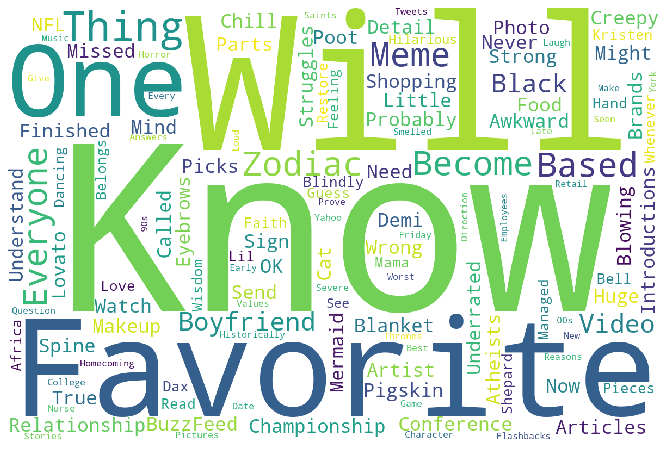

In [18]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt


wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(train[train.label == 'clickbait'].title.values)) 

plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show() 


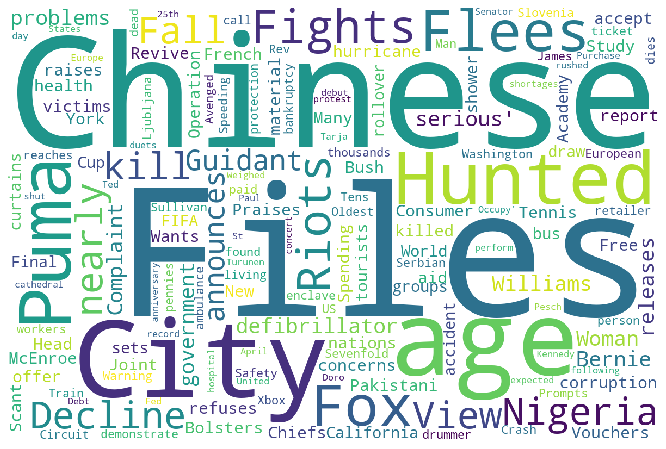

In [19]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt


wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(train[train.label != 'clickbait'].title.values)) 

plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show() 

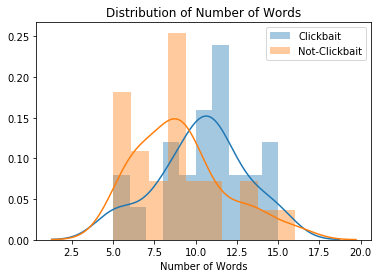

In [4]:
# What is the effect of number of words ? 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

clickbait_length = [len(word_tokenize(title)) for title in train[train.label.values == 'clickbait'].title.values]
not_clickbait_length = [len(word_tokenize(title)) for title in train[train.label.values != 'clickbait'].title.values]

sns.distplot(clickbait_length, bins = 10, label = 'Clickbait')
sns.distplot(not_clickbait_length, bins = 10, label = 'Not-Clickbait')
plt.legend()
plt.title('Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.show()

Looks like Clickbait titles have more words in them. What about mean word length?

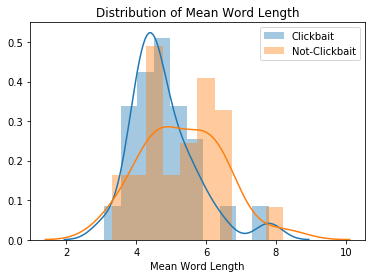

In [5]:
def mean_word_length(x):
    word_lengths = np.array([])
    for word in word_tokenize(x):
        word_lengths = np.append(word_lengths, len(word))
    return word_lengths.mean()


clickbait_length = train[train.label.values == 'clickbait'].title.apply(mean_word_length)
not_clickbait_length = train[train.label.values != 'clickbait'].title.apply(mean_word_length)


sns.distplot(clickbait_length, bins = 10, label = 'Clickbait')
sns.distplot(not_clickbait_length, bins = 10, label = 'Not-Clickbait')
plt.title('Distribution of Mean Word Length')
plt.xlabel('Mean Word Length')
plt.legend()

Clickbait titles use shorter words as compared to non-clickbait titles. Let's check the ratio of stop words.

Clickbait Mean: 0.000
Not clickbait Mean: 0.144


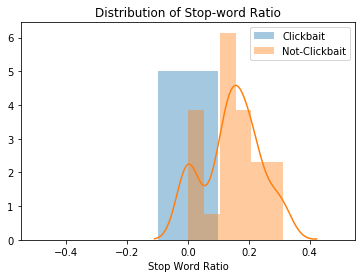

In [7]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
    
    
def stop_words_ratio(x):
    num_total_words = 0
    num_stop_words = 0
    for word in word_tokenize(x):
        if word in stop_words:
            num_stop_words += 1
        num_total_words += 1 
    return num_stop_words/num_total_words


clickbait = train[train.label.values == 'clickbait'].title.apply(stop_words_ratio)
not_clickbait = train[train.label.values != 'clickbait'].title.apply(stop_words_ratio)


sns.distplot(clickbait, norm_hist = True, label = 'Clickbait')
sns.distplot(not_clickbait,  label = 'Not-Clickbait')

print('Clickbait Mean: {:.3f}'.format(clickbait.values.mean()))
print('Not clickbait Mean: {:.3f}'.format(not_clickbait.values.mean()))
plt.title('Distribution of Stop-word Ratio')
plt.xlabel('Stop Word Ratio')
plt.legend()

Strange, the clickbait titles seem to have no stopwords that are in the NLTK stopwords list. This is probably a coincidence because of the train-test split or we need to expand our stop word list. Something to explore during feature engineering for sure. Let's move onto visualizations 

# Visualizations

We'll try both TSNE and PCA with the Bag-of-Words embedding

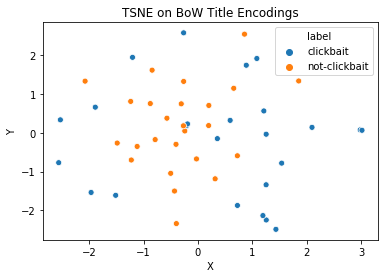

In [15]:
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

bow = CountVectorizer()

x_train = bow.fit_transform(train.title.values)

tsne = TSNE(n_components = 2, n_jobs= -1, verbose = 10, perplexity = 40)
tsne_data = tsne.fit_transform(x_train.todense())

tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['label'] = train.label.values

sns.scatterplot(x = 'X', y = 'Y', hue = 'label', data = tsne_data)
plt.title('TSNE on BoW Title Encodings')
plt.show()

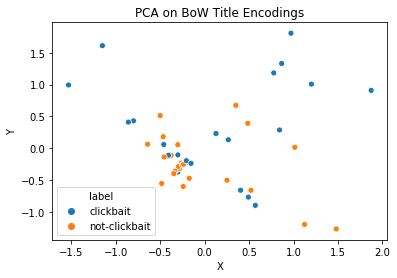

In [17]:
from sklearn.decomposition import PCA


bow = CountVectorizer()

x_train = bow.fit_transform(train.title.values)

pca = PCA(n_components = 2)
pca_data = pca.fit_transform(x_train.todense())


pca_data = pd.DataFrame(pca_data, columns = ['X', 'Y'])
pca_data['label'] = train.label.values

sns.scatterplot(x = 'X', y = 'Y', hue = 'label', data = pca_data)
plt.title('PCA on BoW Title Encodings')
plt.show()

Both the classes seem to be clustered together with BoW embeddings. Lets try some other embedding techniques in the next section.